prerequisites, to correctly execute this jupyter notebook you should have an environment with the following packages:

```
# note that conda-forge is used separately
# note that if you have a GPU you should install tensorflow-gpu and cudatoolkit
# in the first conda install line.

conda create -n keras
conda activate keras
conda install tensorflow jupyter numpy matplotlib scikit-image
conda install -c conda-forge nibabel
```

# Lung Segmentation 

In this notebook we will implement a 3D convolutional U-NET which capable of segmenting the lung volume. Here you will find several exercises to better understand what a U-NET is, how to manage the training pipeline and how to evaluate the outcome of a deep neural network.

![Unet example](unetEX.png)

The image wshows a representation of a UNet structure [1]. The tipical features of a UNet are:
* Left decoding layers
* bottleneck layer (i.e. lowest part of the network)
* Right encoding layers
* Residual sum from decoding to encoding

Here you will not implement a UNet on your own, but in the next blocks (beneath some comments) there will be some *void* section that you will need to write to make this notebook work. Obviously you may look at the answer, but try to perform the tasks on your own as much as you.

We start by importing the packages needed for this work.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
from tensorflow import keras

2022-05-13 11:09:48.646877: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


We start by defining the data used for traning and for testing. In this case, with only 60 images available, we will divide the dataset into 2. 90% of the images will be used in training while the remaining 10% will be used as validation samples during the training. The data is availale in the `data/lctsc` directory. At that path you will find some othe subdirectories composed by a number of 5 digits. Each number represents a patient directory containing the CT image and the lung segmentation mask. 

```
# ls -l data/lctsc/*
data/lctsc/02219:
total 292
-rw-rw-r-- 1 user user 286100 May 12 16:22 ct.nii.gz
-rw-rw-r-- 1 user user  10120 May 12 16:22 lung.nii.gz
...
```

These images are saved in NIfTI format, so you will need to use the [nibabel](https://nipy.org/nibabel/) library to open them. To see how nibabel works and have some practice you can go back to the 3Dimages notebook. 

Now lets go back to our objective -> define test and train dataset. This means you need to define two numpy arrays with 5 dimensions. The first one is the sample dimension (i.e. the index that specifies a certain image, we have 60 images), the following three dimension is the space where the CT scan is defined (i.e. in our specific case 64x64x64) while the last dimension specifies the number of channels (i.e. the ammount of *colors* of the image, 1 for CT images). To define these array follow the next steps:

* list the patients in `data/lctsc` (tip: use glob)
* open the lung ct images with nibabel and store the windowed (1300,-350) image with values from 0 to 1 in the image numpy array (tip: before uploading all the images, define an empty array with the correct dimensions)
* open the lung segmentation images and store the data into the label numpy array (tip: same as above)
* Define the train dataset by taking the first 90% of data from both the preceding arrays
* Define the test dataset by taking the last 10% of the data

**NOTE: don't forget to plot the data to see if you are dooing the correct things**

In [2]:
def windower(data,wmin,wmax):
    """
    windower function, gets in input a numpy array,
    the minimum HU value and the maximum HU value.
    It returns a windowed numpy array with the same dimension of data
    containing values between 0 and 1
    """
    dump = data.copy()
    dump[dump>=wmax] = wmax
    dump[dump<=wmin] = wmin
    dump -= wmin
    w = wmax - wmin
    return dump / w

patients = glob("../data/lctsc/*/")

ct_images  = np.zeros((len(patients),64,64,64,1))
seg_images = np.zeros((len(patients),64,64,64,1))

for i,p in zip(range(len(patients)),patients):
    ct_images[i,...,0]  = windower(nib.load("{}ct.nii.gz".format(p)).get_fdata(),-1000,300)
    seg_images[i,...,0] = nib.load("{}lung.nii.gz".format(p)).get_fdata()
    seg_images[i,...,0][seg_images[i,...,0]>0]=1
    
train_img = ct_images[0:int(0.9*len(patients))]
train_seg = seg_images[0:int(0.9*len(patients))]

test_img = ct_images[int(0.9*len(patients)):]
test_seg = seg_images[int(0.9*len(patients)):]

print(test_img.max(),test_img.min())
print(test_seg.max(),test_seg.min())

1.0 0.0
1.0 0.0


/home/postuma/miniconda3/envs/keras/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


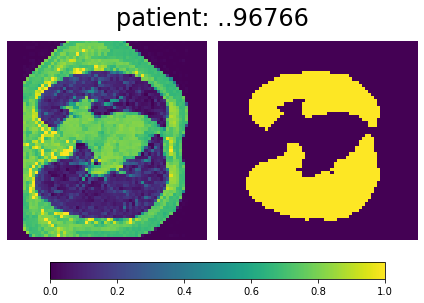

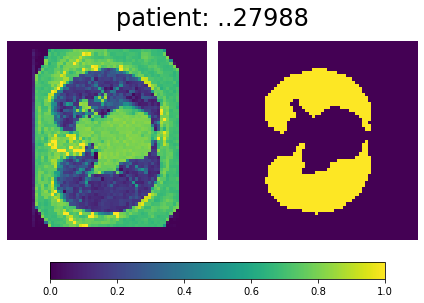

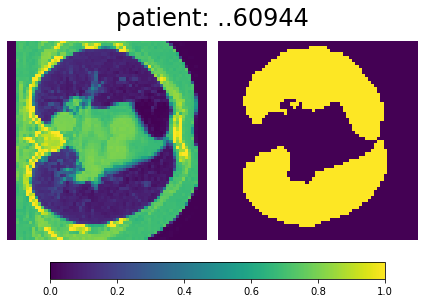

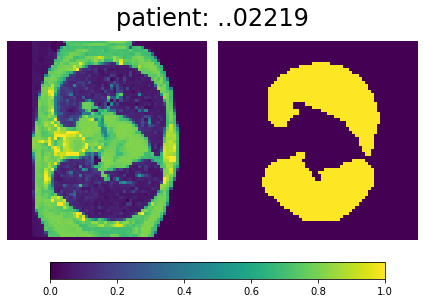

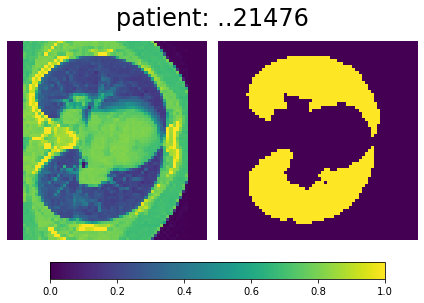

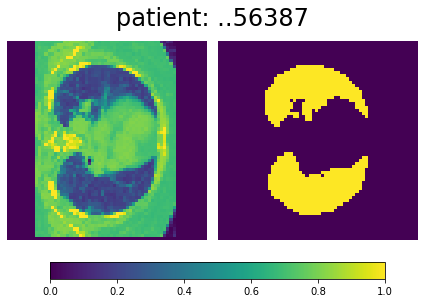

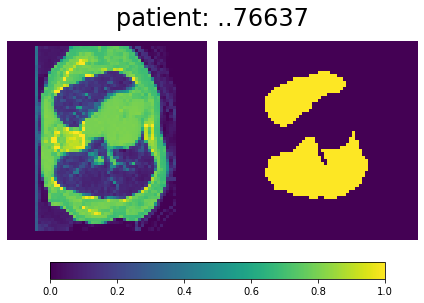

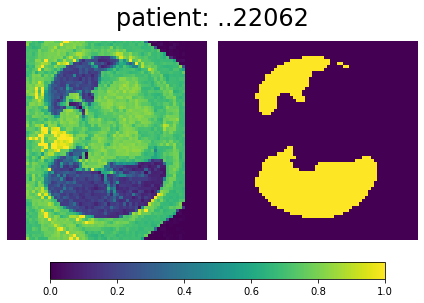

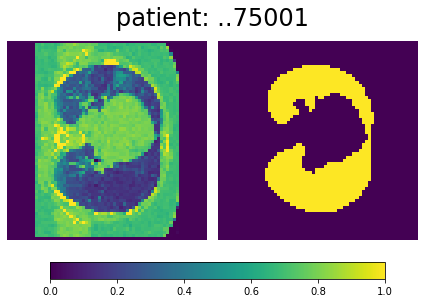

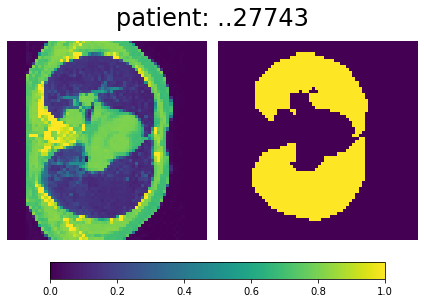

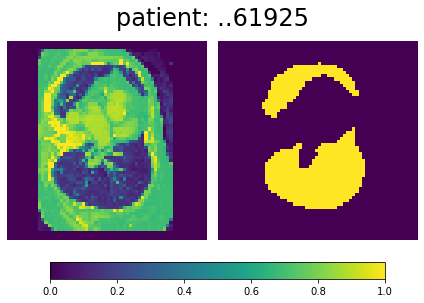

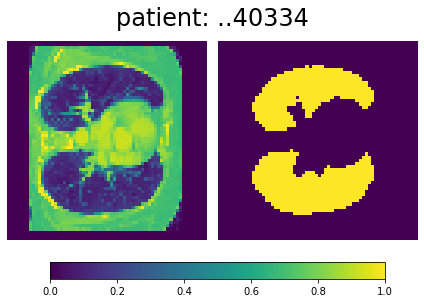

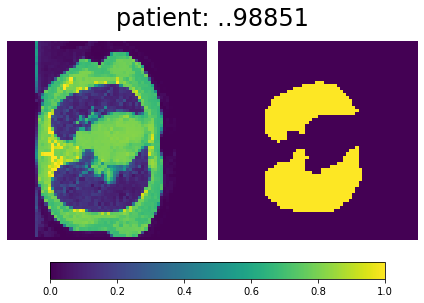

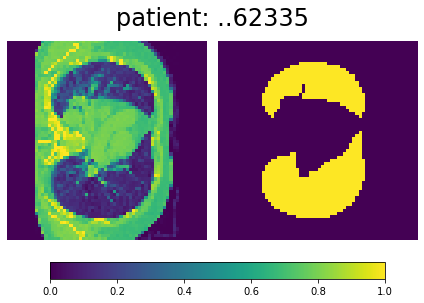

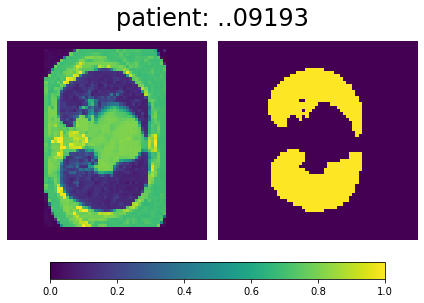

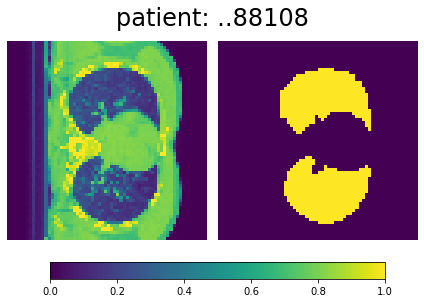

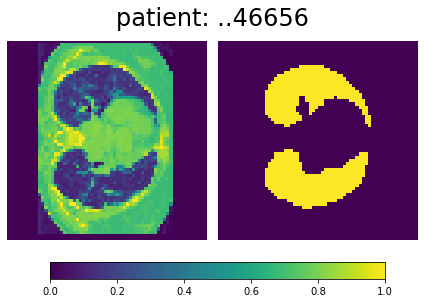

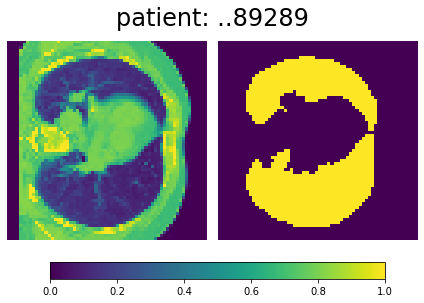

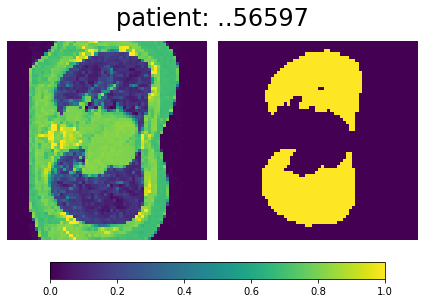

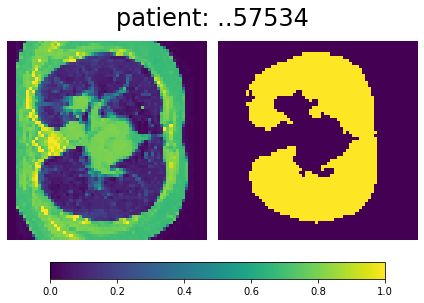

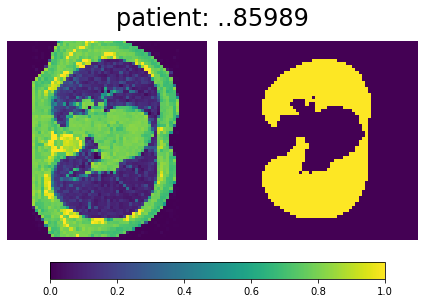

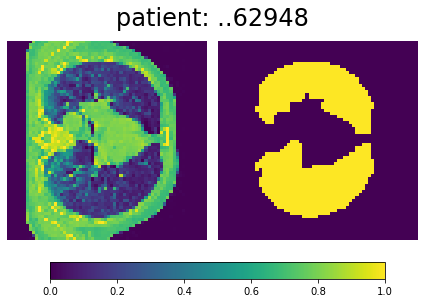

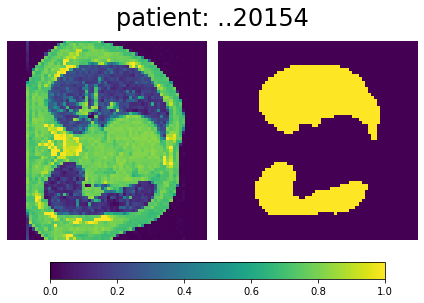

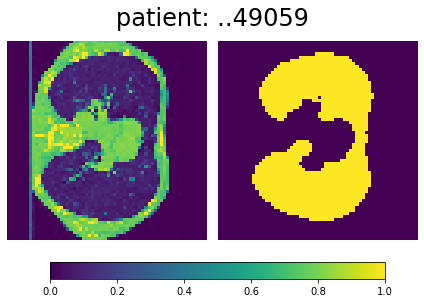

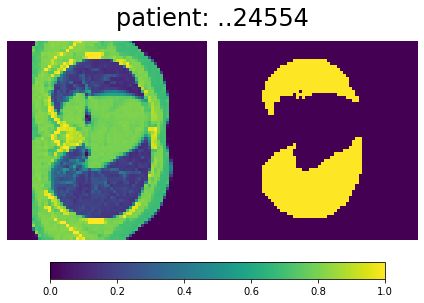

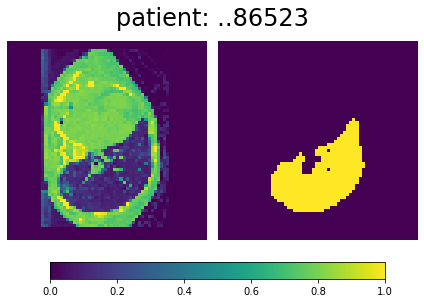

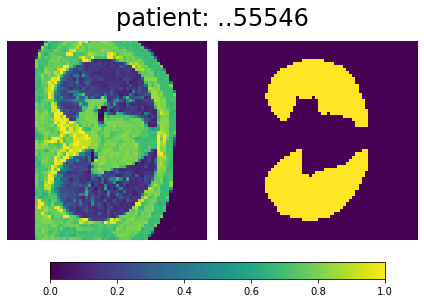

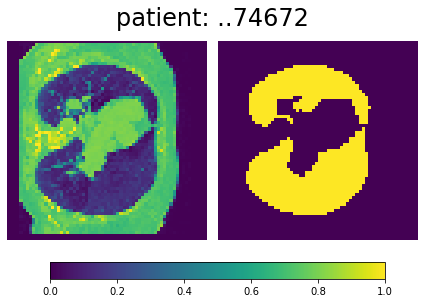

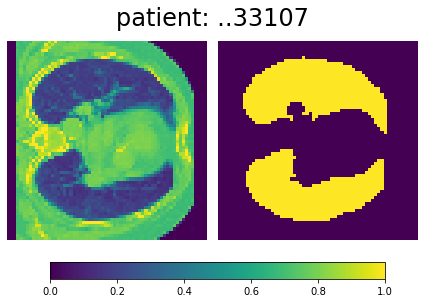

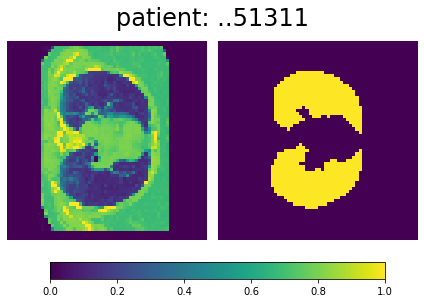

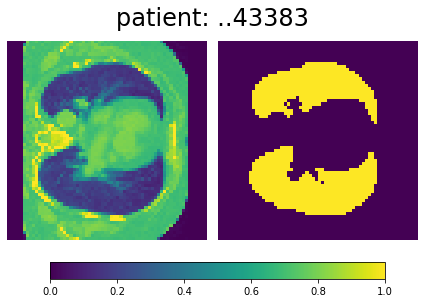

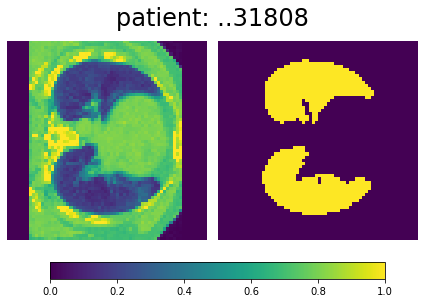

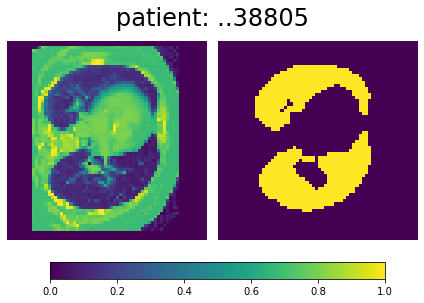

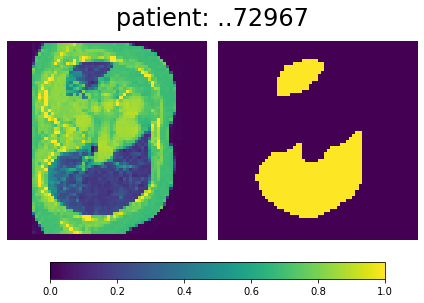

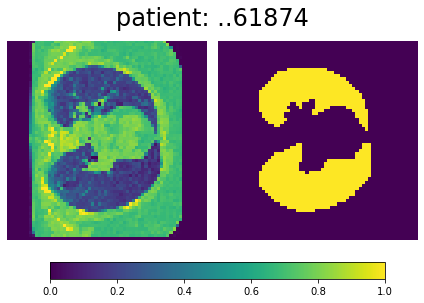

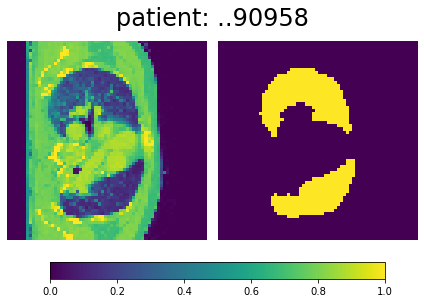

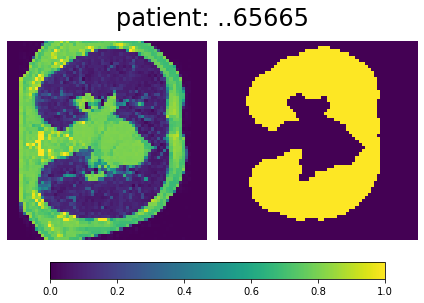

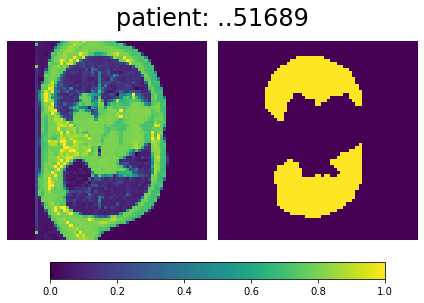

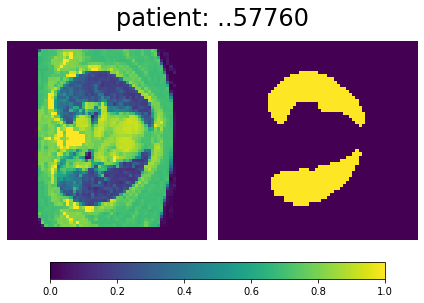

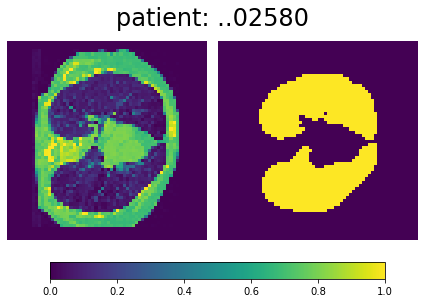

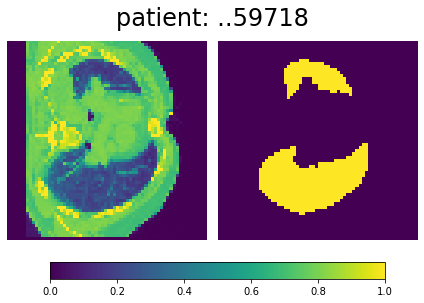

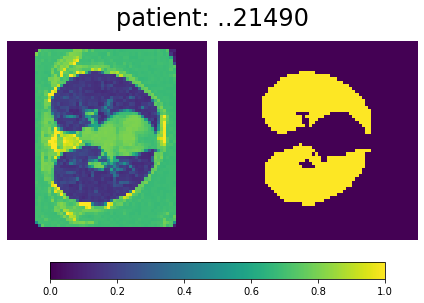

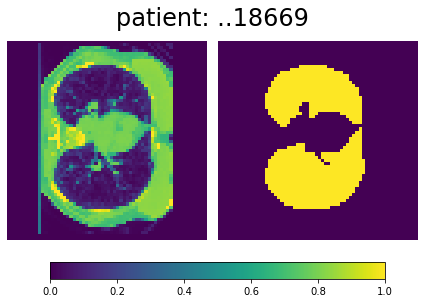

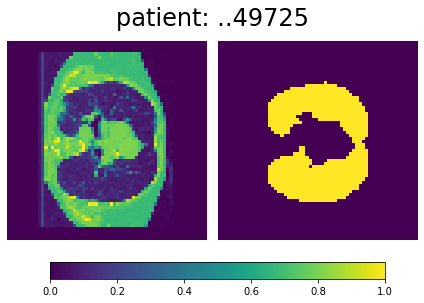

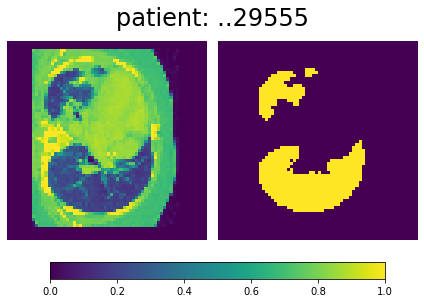

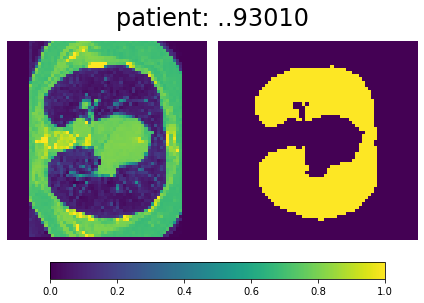

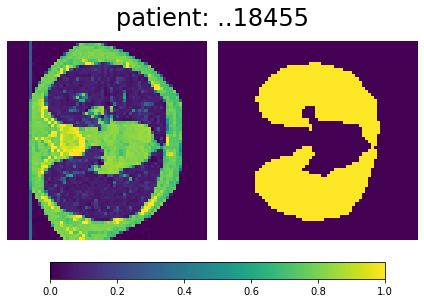

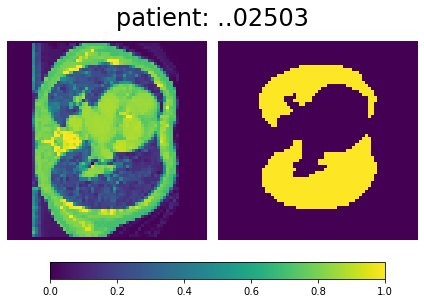

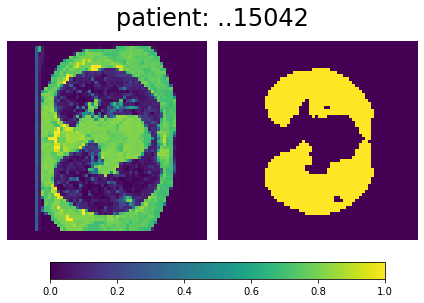

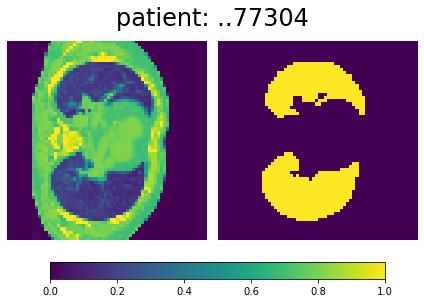

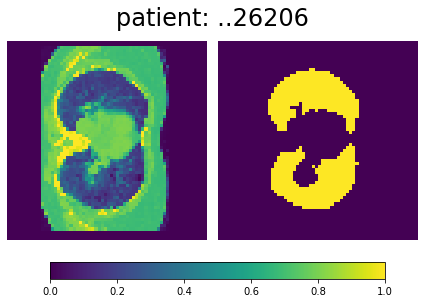

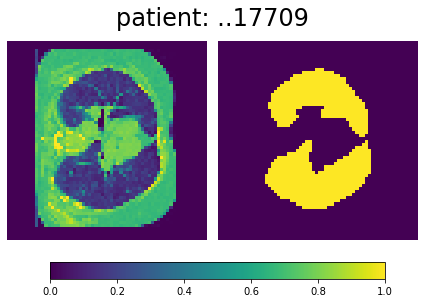

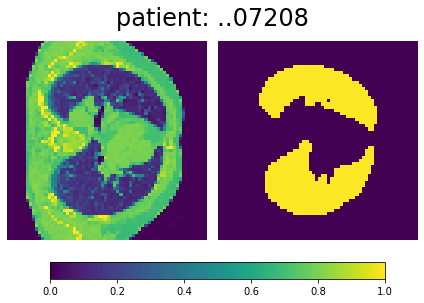

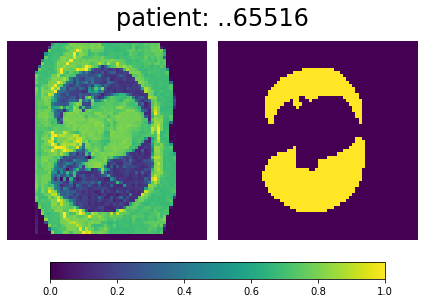

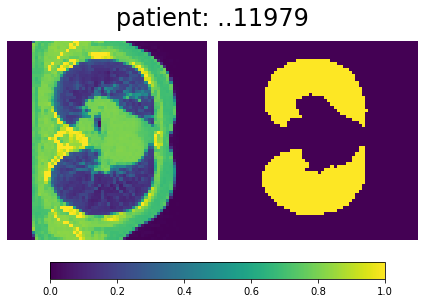

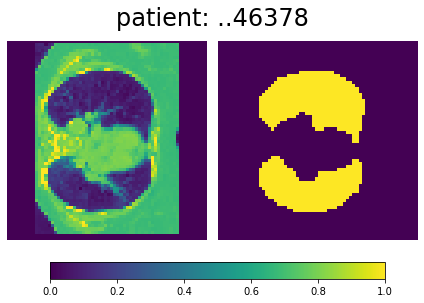

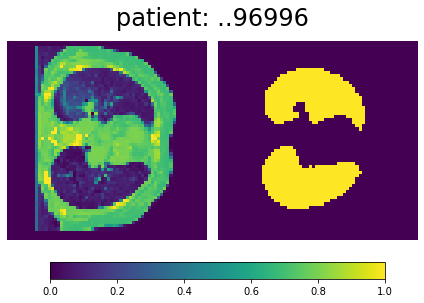

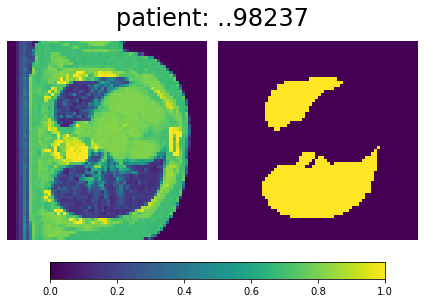

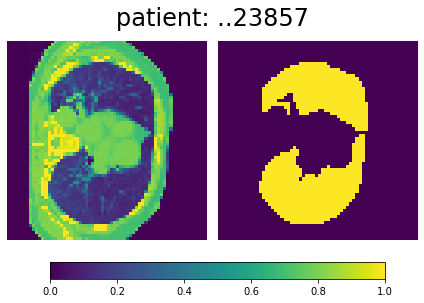

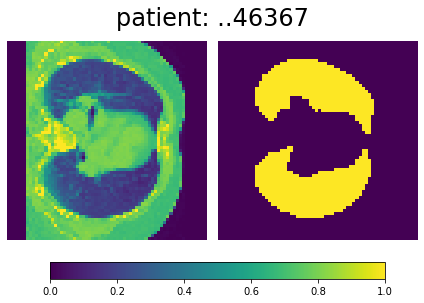

In [3]:
for p,ct,seg in zip(patients,ct_images,seg_images):
    fig,ax=plt.subplots(1,2,tight_layout=True,sharey=True)
    fig.suptitle("patient: {}".format(p.replace('/','').replace('datalctsc','')),size=24,y=0.85)
    im=ax[0].imshow(ct[...,32,0],vmin=0,vmax=1)
    ax[1].imshow(seg[...,32,0],vmin=0,vmax=1)
    for a in ax:
        a.axis("off")
    fig.colorbar(im, ax=ax, location='bottom', orientation='horizontal', anchor=(.5,-4))
    plt.show()
    plt.close()

It is now time to complicate things and start defining the Unet neural network model. To make things a little bit more easy, there are 2 predefined *layer* functions: `down` and `up`. The first function is the one that decodes the image into features while the latter one encodes the features back into a masked image. The `down` function needs as an input a layer and the number of filters to output after the convolution. While the `up` function needs the same variable with in addition the corresponding layer of the decoding process which will be concatenated to the encoding layer. Both function return a processed layer, the down layer with half the spacial dimensions and k filters as channels, the up layer returns a layer with double the spacial dimensions an k filters as channels.

for example, down:
```
    down(input,8)                 output
  input layer shape         output layer shape
(None, 64, 64, 64, 1)  --> (None, 32, 32, 32, 8)
```

up:
```
    down(input,16)                 output
  input layer shape          output layer shape
(None, 16, 16, 16, 32)  --> (None, 32, 32, 32, 16)
```

The full unerstanding of how the layers are interconnected is out of the scope of this notebook. The important things to remember are:

* maxpooling3D: `input (None, X, Y, Z, l) -> output (None, X/2, Y/2, Z/2, l)`
* upsampling3D: `input (None, X, Y, Z, l) -> output (None, X*2, Y*2, Z*2, l)`
* conv3D(l, padding='same'): `input (None, X, Y, Z, l') -> output (None, X, Y, Z, l)`
* conv3DTranspose(l, padding='same'): `input (None, X, Y, Z, l') -> output (None, X, Y, Z, l)`

Now, try to complete the model by following the tips in the comments. At the end try to display the model by using the `summary` method on the model.


In [4]:
# down
def down(previous_layer,k, **kargs):
    d = keras.layers.Conv3D(k,3,padding="same",**kargs)(previous_layer)
    d = keras.layers.BatchNormalization()(d)
    d = keras.layers.Activation('relu')(d)
    d = keras.layers.Conv3D(k,3,padding="same",**kargs)(d)
    d = keras.layers.BatchNormalization()(d)
    d = keras.layers.Activation('relu')(d)
    d = keras.layers.Conv3D(k,3,padding="same",**kargs)(d)
    d = keras.layers.BatchNormalization()(d)
    d = keras.layers.MaxPooling3D()(d)

    res = keras.layers.Conv3D(k,3,strides=2,padding="same",**kargs)(previous_layer)
    d = keras.layers.Add()([res,d])
    d = keras.layers.Activation('relu')(d)
    return d

# up
def up(previous_layer,down_layer,k, **kargs):
    u = keras.layers.Conv3DTranspose(k,3,padding="same",**kargs)(previous_layer)
    u = keras.layers.BatchNormalization()(u)
    u = keras.layers.Activation('relu')(u)
    u = keras.layers.Concatenate(axis=-1)([u,down_layer])
    u = keras.layers.Conv3D(k,3,padding="same",**kargs)(u)
    u = keras.layers.BatchNormalization()(u)
    u = keras.layers.Activation('relu')(u)
    u = keras.layers.Conv3D(k,3,padding="same",**kargs)(u)
    u = keras.layers.BatchNormalization()(u)
    u = keras.layers.UpSampling3D()(u)

    res = keras.layers.UpSampling3D()(previous_layer)
    res = keras.layers.Conv3D(k,1,padding="same",**kargs)(res)
    u = keras.layers.Add()([u,res])
    u = keras.layers.Activation('relu')(u)
    return u

def model(input_shape=(64,64,64,1),k1=8,reg=0.1):
    inputs=keras.layers.Input(shape=(input_shape))
    
    initializer = keras.initializers.Constant(1.)
    params = {"kernel_regularizer" : keras.regularizers.l2(reg), 
              "kernel_initializer" : 'random_normal'}
        
    d1 = down(inputs,k1)
    d2 = down(d1,k1*2)
    d3 = down(d2,k1*4)
    
    # bottleneck
    b = keras.layers.Conv3D(k1*8,3,padding="same",**params)(d3)
    b = keras.layers.BatchNormalization()(b)
    b = keras.layers.Activation('relu')(b)
    b = keras.layers.Conv3D(k1*8,3,padding="same",**params)(b)
    b = keras.layers.BatchNormalization()(b)
    b = keras.layers.Activation('relu')(b)
        
    u1 = up(b ,d3,k1*4)
    u2 = up(u1,d2,k1*2)
    u3 = up(u2,d1,k1)
    
    out = keras.layers.Conv3D(1,3,padding="same",**params)(u3)
    out = keras.activations.sigmoid(out)
    
    model=keras.models.Model(inputs=inputs,outputs=out)
    
    return model

keras.backend.clear_session()
unet = model()
unet.summary(line_length=150)
    
    
    

2022-05-13 11:09:59.081558: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-13 11:09:59.082324: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2020.4.304/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2020.4.304/linux/mpi/intel64/libfabric/lib:/opt/intel/compilers_and_libraries_2020.4.304/linux/mpi/intel64/lib/release:/opt/intel/compilers_and_libraries_2020.4.304/linux/mpi/intel64/lib:/opt/intel/compilers_and_libraries_2020.4.304/linux/ipp/lib/intel64:/opt/intel/compilers_and_libraries_2020.4.304/linux/mkl/lib/intel64_lin:/opt/intel/compilers_and_libraries_2020.4.304/linux/tbb/lib/intel64/gcc4.8:/opt/intel/debugger_2020/python/intel64/lib:/opt/intel/debugger_2020/libipt/intel64/lib:/opt/intel/compilers_and

Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 64, 64, 64, 1)]          0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d (Conv3D)                                  (None, 64, 64, 64, 8)            224               input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
batch_normalization (BatchNormalization)         (None, 64, 64, 64, 8)         

It is now time to define the second most important part of a neural networ, the loss function. This is a measure of the distance between the predicted image and the target image. This function is used to compute the derivative of the network weights, so it must be differentiable. For this model we will use the dice loss, defined as $2\times\frac{A\cap B}{A\cup B}$ where A and B are respectively the volume of the reference map while B the predicted mask. The following image is a pictorical view of the same concept.

![dice_img](dice.png)

Here you should try to define 2 function, the `Dice` and `DiceLoss`. This latter one defined as 1-`Dice`. To define these functions you should use these keras functions:

* keras.backend.flatten
* keras.backend.sum

**note: try to think a way to avoid the division by zero.**

In [5]:
def Dice(targets, inputs, smooth=1e-6):

    #flatten label and prediction tensors
    inputs = keras.backend.flatten(inputs)
    targets = keras.backend.flatten(targets)

    intersection = keras.backend.sum(targets*inputs)
    dice = (2*intersection + smooth) / (keras.backend.sum(targets) + keras.backend.sum(inputs) + smooth)
    
    return dice

def DiceLoss(targets, inputs, smooth=1e-6):
    return 1 - Dice(targets, inputs, smooth=1e-6)

Other than the loss function one has to decide which algorithm to use as an optimizer, we will use the Adam optimizer. Once this is defined the model can be compiled. We added as a metric to evaluate (both on train and validatio) the Dice coefficient.

In [6]:
adam = keras.optimizers.Adam(
    learning_rate=0.0001, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-08, 
    amsgrad=True)

unet.compile(
    loss=DiceLoss,
    optimizer=adam,
    metrics=[Dice])

While training we can change some of the values of the optimizer, in particular we can force to change the learning rate of the model accordinf to a metric. This can be performed by `keras.callbaks`methods and the metric we want to optimize is the validation dice. In the following block the variable to perform this task is define but not implemented in the fit function. try to use *google* to understand how to use this variable in fit. At the end of the fit, try to save the model as "lung_net".

In [7]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_Dice', 
    factor=0.5, patience=5, 
    min_lr=0.000005, verbose= True)

# unet = keras.models.load_model("Answer/lung_unet")
load_status  = unet.load_weights("lung_unet.hdf5")

#history = unet.fit(
#    train_img,
#    train_seg,
#    epochs=3,
#    batch_size=1,
#    validation_data=(test_img,test_seg),
#    callbacks=[reduce_lr])

#unet.save('lung_unet')

Now you have a trained model (if not upload the trained model from `Answers/lung_net`) try to infer (i.e. predict) the results on the test set. Try to plot the results and compare the plots with the ground trueth data.

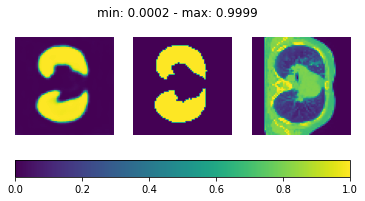

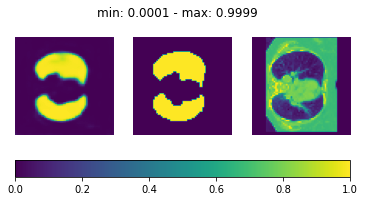

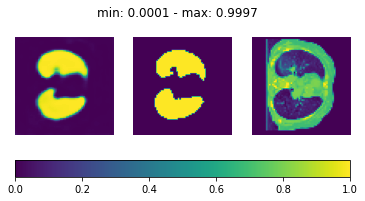

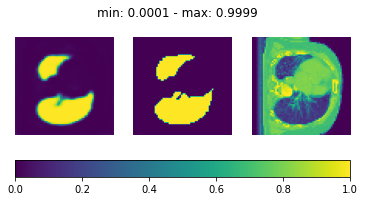

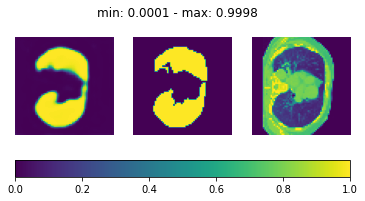

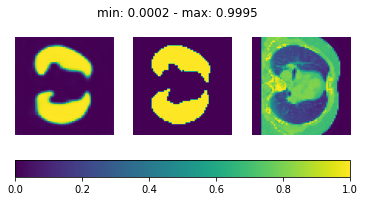

In [18]:
res = unet.predict(test_img)

for i,r,ct,gt in zip(range(len(res)),res,test_img,test_seg):
    fig, ax = plt.subplots(1,3)
    fig.suptitle("min: {:1.4f} - max: {:1.4f}".format(r.min(),r.max()),y=.8)
    im = ax[0].imshow(r[...,32,0],vmin=0,vmax=1)
    ax[1].imshow(gt[...,32,0],vmin=0,vmax=1)
    ax[2].imshow(ct[...,32,0],vmin=0,vmax=1)
    fig.colorbar(im, ax=ax, location='bottom', orientation='horizontal', anchor=(.5,1.5))
    for a in ax:
        a.axis('off')
    plt.show()
    plt.close()

other things you should try to evaluate to study how to improve the network model:

* evaluate training histrory loss and metrics
* Try to implement other metrics to evaluate the results,

## References

[1] Kamnitsas, Konstantinos, et al. "Ensembles of multiple models and architectures for robust brain tumour segmentation." International MICCAI brainlesion workshop. Springer, Cham, 2017.

[2] [Lung CT Segmentation Challenge 2017](https://wiki.cancerimagingarchive.net/display/Public/Lung+CT+Segmentation+Challenge+2017)